# Robust MPC

We want to implement the worst-case robust MPC example from the lecture from Slide 6. We have the following LTI dynamics

$$ x_{k+1} = x_k + u_k + w_k$$

with $x_k \in \mathbb{R}$ and $u_k \in \mathbb{R}$.
Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{min}_{u,x} & \sum_{k=0}^{K-1} x_k^2 + u_k^2\\
\mbox{s.t.} & x_{k+1} = x_k + u_k + w_k\\%, \quad k=0, \ldots, K-1\\
& | x_k|\leq 1, \quad x_0 = 1.
\end{array}

It is enough to implement the constraints for the worst-case noise realizations, so $w_{max} = [0.5,0.5, 0.5, 0.5....]$ and $w_{min} = [-0.5,-0.5, -0.5, -0.5....]$.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import random

# WTF? Wait for printouts or solutions, else very hard to solve!

In [2]:


#%% Feedback MPC
n_x, n_u = 1, 1
K = 5
A = 1
B = 1
q = 1
r = 1
T = 30


# Maximum disturbance values, as the set is not time-varying these are constant for all k = 0,..., K
w_min = -0.5
w_max = 0.5

x_0 = np.array(1)

x_realized_traj = np.zeros([n_x, T+1])
x_realized_traj[:, 0] = x_0
u_traj =  np.zeros([n_u, T])

for t in range(T):

    x_nom = cp.Variable((1, K + 1))
    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    u = cp.Variable((1, K))

    cost = 0
    constr = []
    for k in range(K):
        cost += cp.quad_form(x_nom[:,k],q*np.eye(n_x)) + cp.quad_form(u[:,k],r*np.eye(n_u))

        constr += [x_nom[:, k + 1] == A * x_nom[:, k] +  B * u[:, k] ,
                   x_min[:, k + 1] == A * x_min[:, k] + B * u[:, k] + w_min ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == A * x_max[:, k]+  B * u[:, k] + w_max,
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = True)

    if problem.status == "infeasible_inaccurate":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break

    w_realized = random.uniform(w_min, w_max)
    x_0 = A * x_0 + B * u[:,0].value + w_realized

    u_traj[:, t] = u[:,0].value
    x_realized_traj[:, t+1] = x_0





(CVXPY) Aug 13 07:12:56 PM: Your problem has 23 variables, 27 constraints, and 0 parameters.
(CVXPY) Aug 13 07:12:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 13 07:12:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 13 07:12:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 13 07:12:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Aug 13 07:12:56 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 13 07:12:56 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Aug 13 07:12:56 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 13 07:12:56 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 13 07:12:56 PM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 13 07:12:56 PM: Applying reduction OSQP
(CVXPY) Aug 13 07:12:56 PM: Finished problem compilation (t

                                     CVXPY                                     
                                     v1.7.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 43, constraints m = 57
          nnz(P) + nnz(A) = 127
settings: algebra = Built-in,
          OSQPInt = 4

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

**Question 1:**

Can you find an initial state for which the robust MPC problem above is feasible? Why not? Why can the MPC not solve this simple problem?

**Answer 1:**
No, the disturbance is too much 

# Feedback MPC

Now using the same example from the lecture, we want to design a feedback MPC policy
\begin{equation}
\pi_k(x_k, \mathbf{v})=v_k + L x_k
\end{equation}
wich renders the optimal control problem above feasible.

We use the same worst-case approach, but cancel some of the effect of the disturbance using the state-feedback.

In [3]:
#%% Feedback MPC
n_x, n_u = 1, 1

K = 5
A = 1
B = 1
q = 1
r = 1
L = -1


# Maximum disturbance values, as the set is not time-varying these are constant for all k = 0,..., K
w_min = -0.5
w_max = 0.5

x_0 = np.array(1)

x_realized_traj = np.zeros([n_x, T+1])
x_realized_traj[:, 0] = x_0
v_traj =  np.zeros([n_u, T])


for t in range(T):

    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    v = cp.Variable((1, K))

    cost = 0
    constr = []
    for k in range(K):
        #policy
        pi_min = v[:,k] + L*x_min[:,k]
        pi_max = v[:,k] + L*x_max[:,k]
        pi_nom = v[:,k] + L*x_nom[:,k]

        cost += cp.quad_form(x_nom[:,k],q*np.eye(n_x)) + cp.quad_form(pi_nom,r*np.eye(n_u))
        constr += [x_nom[:, k + 1] == A * x_nom[:, k] +  B * pi_nom ,
                   x_min[:, k + 1] == A * x_min[:, k] +  B * pi_min + w_min ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == A * x_max[:, k]+ B * pi_max + w_max,
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0, x_nom[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)

    if problem.status == "infeasible":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break

    w_realized = random.uniform(w_min, w_max)
    x_0 = (A + B*L) * x_0 + B * v[:,0].value + w_realized

    v_traj[:, t] = v[:,0].value
    x_realized_traj[:, t+1] = x_0

**Question 2:**

For which values of the state-feedback gain $L$ and initial values $x_0$ is the Feedback MPC problem above feasible? Explain, why is it not feasible, for $L= 0.25$ and $x_0 = 0$ ?

You can plot the outputs below.


**Asnwer 2:**

See solution

Text(0.5, 0, '$t$')

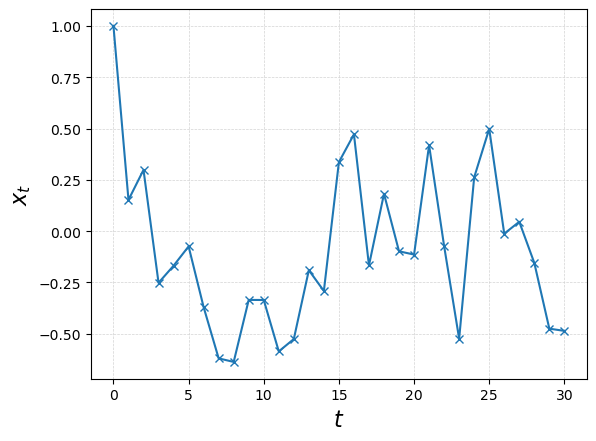

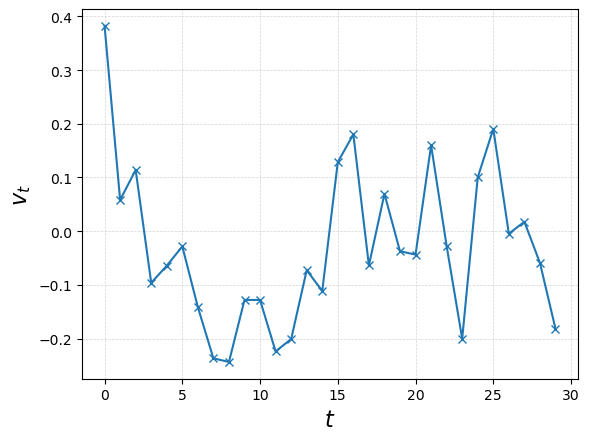

In [4]:
# Plotting
f1 = plt.figure()
plt.plot(x_realized_traj[0,:], marker = 'x')


plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$x_t$", fontsize=16)




f2 = plt.figure()

plt.plot(v_traj[0,:].round(4), marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$v_t$", fontsize=16)
plt.xlabel("$t$", fontsize=16)

General note if the disturbances come from a probability distribution:

This "worst-case" robust approach only works for disturbances coming from bounded distributions, where you would take the the max and min bounds of the distribution and apply the same procedure. Note however that such a robust approach does not take into account the likelihood of disturbance realizations at the boundary but rather ensures constraint satisfaction at all times but which will lead to conservatism of the solution and feasibility issues as we have seen in the exercises aboce. In some applications it is preferable to work with probabilistic constraints ("chance constraints") but this is not covered in the course. See this article for further reading:

A. Mesbah, "Stochastic Model Predictive Control: An Overview and Perspectives for Future Research," in IEEE Control Systems Magazine, vol. 36, no. 6, pp. 30-44, Dec. 2016, doi: 10.1109/MCS.2016.2602087.

# Economic MPC vs Tracking MPC

We have the following LTI dynamics

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 0.857 & 0.884 \\ -0.0147& -0.0151 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  8.57\\ 0.884\end{smallmatrix}\right] u_k.$$

with $x_k \in \mathbb{R}^2$ and $u_k \in \mathbb{R}$.
Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} g(x_k, u_k)\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{\infty}\leq 1, \quad x_0 = \left[\begin{smallmatrix} 80 \\ 10 \end{smallmatrix}\right].
\end{array}

Where the tracking MPC has the following cost function:
\begin{equation}
g_{tr}(x_k, u_k) = \|x_k -x_s \|^2_Q + \| u_k -u_s\|_R^2
\end{equation}
with $Q = \left[\begin{smallmatrix} 2& 0 \\ 0 & 2 \end{smallmatrix}\right]$ and $R = 2$.

The economic MPC has the following economic cost function:

\begin{equation}
g_{e}(x_k, u_k) = q^T x_k + r\, u_K
\end{equation}

with $q =  \left[\begin{smallmatrix}  -3\\-2\end{smallmatrix}\right]$ and $r = -2$.

In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


n_x, n_u = 2,1

A = np.array([[0.857, 0.884], [-0.0147, -0.0151]])
B = np.array([[8.57], [0.884]])
T = 30
K= 7

### Exercise 1:

Compute the economically optimal steady state and input pair $x_s$ and $u_s$.

In [4]:
#%% Solve steady-state problem with economic cost and input constraints

x_s = cp.Variable((n_x, 1))
u_s = cp.Variable((n_u, 1))

r = -2
q = np.array([-3,-2])

cost = 0
constr = []

cost +=  q @ x_s[:, 0] + r * u_s[:, 0]
constr += [x_s[:, 0] == A @ x_s[:,0] + B * u_s[:, 0], cp.norm(u_s[:, 0], 'inf') <= 1]

# sums problem objectives and concatenates constraints.

problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(verbose = False)

x_s = x_s.value.round().reshape(-1,)
u_s = u_s.value.round().reshape(-1,)

print('The economically optimal steady-state input is:'+ str(u_s))
print('The economically optimal steady state is:'+ str(x_s))

The economically optimal steady-state input is:[1.]
The economically optimal steady state is:[60.  0.]


/opt/conda/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


### Exercise 2:

Fill in the lines of code below for the tracking MPC and the economic MPC. Compare the two outputs and answer the questions.

In [5]:
#%%
n_x, n_u = 2,1
Q = 2*np.eye(n_x)
R = 2

x_0 = np.array([80,10])

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  cp.quad_form(x[:, k] - x_s,Q) + R * (u[:, k]- u_s)**2
        constr += [x[:, k + 1] == A @ x[:, k] + B * u[:, k], cp.norm(u[:, k], 'inf') <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False,solver=cp.SCS )

    x_0 = A @ x_0 + B * u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0

u_tra = u_traj.copy()
x_tra = x_traj.copy()

/opt/conda/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.12/site-packages/cvxpy/expressions/expression.py:683: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.12/

ValueError: could not broadcast input array from shape (2,2) into shape (2,)

In [ ]:
r = ### FILL IN HERE
q = ### FILL IN HERE

x_0 = ### FILL IN HERE

x_traj = np.zeros([n_x, T+1])
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):

    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))

    cost = 0
    constr = []
    for k in range(K):
        cost +=  ### FILL IN HERE
        constr += [### FILL IN HERE, ### FILL IN HERE]
    # sums problem objectives and concatenates constraints.
    constr += [### FILL IN HERE]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)

    x_0 = A @ x_0 + B * u[:,0].value

    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0

u_eco = u_traj.copy()
x_eco = x_traj.copy()

In [ ]:
%config InlineBackend.figure_format = 'svg'

f1 = plt.figure()

plt.plot(x_tra[0,:], x_tra[1,:], marker = 'x')
plt.plot(x_eco[0,:], x_eco[1,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$(x_k)_1$", fontsize=16)
plt.ylabel("$(x_k)_2$", fontsize=16)
plt.legend(['Tracking MPC', 'Economic MPC'])

f2 = plt.figure()

plt.plot(u_tra[0,:], marker = 'x')
plt.plot(u_eco[0,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$u_k$", fontsize=16)
plt.xlabel("$t$", fontsize=16)
plt.legend(['Tracking MPC', 'Economic MPC'])

**Question 3:**

Why is the output of the economic MPC different to the tracking MPC?



**Question 4:**

Which of the two controllers gives the lower **economic** cost? You can either compute it above in code or make cost function arguments.



**Question 5:**

Why does the economic MPC converge to the optimal steady state of the system if there is no terminal state constraint to do so?



**Question 6:**

Can you modifiy the cost matrices of the tracking MPC problem such that the two outputs match?